# Text entailment using BERT model

Fine tunning helper resources: 
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://huggingface.co/docs/transformers/training
- https://www.kaggle.com/ibauman/classification-bert

In [1]:
%pip install wget

You should consider upgrading via the '/Users/yehuda/Sites/mta/nlp/project/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [39]:
import os
import torch
import random
import wget
import zipfile
import gc
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [125]:
MODEL_VERSION = 1.0
MODEL_VERSION2 = 1.0
MODEL_PATH = f'./saved_model/{MODEL_VERSION}'
MODEL_PATH2 = f'./saved_model2/{MODEL_VERSION2}'
MODEL_HISTORY_PATH = f'{MODEL_PATH}/history.csv'
MODEL_HISTORY_PATH2 = f'{MODEL_PATH2}/history.csv'

DATASET_URL = 'https://nlp.stanford.edu/projects/snli/snli_1.0.zip'
DATASET_DIR_PATH = './data'
DATASET_NAME = 'snli_1.0'
DATASET_DOWNLOAD_PATH = f'{DATASET_DIR_PATH}/{DATASET_NAME}.zip'

DATA_DEV = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_dev.txt'
DATA_TEST = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_test.txt'
DATA_TRAIN = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_train.txt'
DATA_TOKENIZE_DEV = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_dev_.pkl'
DATA_TOKENIZE_TEST = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_test.pkl'
DATA_TOKENIZE_TRAIN = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_train.pkl'

MAX_EPOCH = 3
BATCH_SIZE = 32

LABELS = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
LABELS2 = {'neutral': 0, 'contradiction': 0, 'entailment': 1}

## Downalod the SNLI dataset

In [91]:
if not os.path.isdir(DATASET_DIR_PATH):
    os.mkdir(DATASET_DIR_PATH)
    wget.download(DATASET_URL, out=DATASET_DOWNLOAD_PATH)
    
    with zipfile.ZipFile(DATASET_DOWNLOAD_PATH, 'r') as z:
        z.extractall(DATASET_DIR_PATH)
        os.remove(DATASET_DOWNLOAD_PATH)

Select the device for the pytorch

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Load BERT tokenizer

In [93]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

## Dataset Preprocessing
1. Load the data from the csv files
2. Clean the data 
    - Remove null
    - Remove rows without gold label ("-" value)
3. Create sequence from the sentences 1 and 2
4. Tokenize the sequence for finding the max sequence token length - later we will padding all the rest of the smaller sequences
5. Find the max sequence tokens length
6. Encode all the sequences with padding by the max length from earlier (getting the input ids and the attention mask)
7. Save the results as pickle for the later use

In [126]:
class snli_preprocessing(object):
    def __init__(self, csv_file: str, save_path: str, tokenizer: BertTokenizer):
        self.data = pd.read_csv(csv_file, sep='\t')
        self.save_path = save_path
        self.tokenizer = tokenizer

    def clean(self):
        self.data = self.data[['gold_label', 'sentence1', 'sentence2']]
        self.data = self.data[self.data['gold_label'] != '-']
        self.data.dropna(inplace=True)

    def tokenize(self):
        self.data['sequence'] = '[CLS]' + self.data['sentence1'] + '[SEP]' + self.data['sentence2'] + '[SEP]'
        self.data['tokens'] = self.data['sequence'].apply(self.tokenizer.tokenize)
        self.data['gold_label_int'] = self.data['gold_label'].apply(lambda l: LABELS[l])

    def max_length(self) -> int:
         # +3 is for [SEP] [SEP] [CLS]
        return len(max(self.data['tokens'], key=len)) + 3

    def encode(self, max_len: int):
        def process(sequence: str, max_len: int):
            return self.tokenizer.encode_plus(
                sequence,
                return_tensors='pt',
                add_special_tokens=True,
                return_attention_mask=True,
                padding='max_length',
                max_length=max_len,
            )

        tokens = self.data['sequence'].apply(lambda seq: process(seq, max_len))
        self.data[['input_ids', 'token_type_ids', 'attention_mask']] = tokens.apply(pd.Series)
        self.data.drop(['tokens'], axis=1, inplace=True)

    def save(self):
        self.data.to_pickle(self.save_path)

In [120]:
if not os.path.isfile(DATA_TOKENIZE_TRAIN) and not os.path.isfile(DATA_TOKENIZE_DEV) and not os.path.isfile(DATA_TOKENIZE_TEST):
    print('Tokenize the dataset')

    train = snli_preprocessing(csv_file=DATA_TRAIN, save_path=DATA_TOKENIZE_TRAIN, tokenizer=tokenizer)
    dev = snli_preprocessing(csv_file=DATA_DEV, save_path=DATA_TOKENIZE_DEV, tokenizer=tokenizer)
    test = snli_preprocessing(csv_file=DATA_TEST, save_path=DATA_TOKENIZE_TEST, tokenizer=tokenizer)

    max_len = 0
    dataset = [train, dev, test]

    for data in dataset:
        data.clean()

        # basic tokenize to find the max sentences length
        data.tokenize() 

        data_max_len = data.max_length()
        max_len = data_max_len if data_max_len > max_len else max_len

    # encode after find the max sentences length in the dataset
    for data in dataset:
        data.encode(max_len)
        data.save()

    train, dev, test = train.data, dev.data, test.data

    print(f'Max length: {max_len}')

else:   
    print('The dataset already tokenized')
    
    train = pd.read_pickle(DATA_TOKENIZE_TRAIN)
    dev = pd.read_pickle(DATA_TOKENIZE_DEV)
    test = pd.read_pickle(DATA_TOKENIZE_TEST)


The dataset already tokenized


In [97]:
def create_tensor_dataset(dataset: pd.DataFrame):
    input_ids = torch.cat(tuple(dataset['input_ids'].values))
    attention_mask = torch.cat(tuple(dataset['attention_mask'].values))
    labels = torch.tensor(dataset['gold_label_int'].values)

    return TensorDataset(input_ids, attention_mask, labels)

In [98]:
train_tensor = create_tensor_dataset(train)
dev_tensor = create_tensor_dataset(dev)
test_tensor = create_tensor_dataset(test)

In [99]:
train_loader = DataLoader(train_tensor, batch_size=BATCH_SIZE, sampler=RandomSampler(train_tensor))
dev_loader = DataLoader(dev_tensor, batch_size=BATCH_SIZE, sampler=SequentialSampler(dev_tensor))
test_loader = DataLoader(test_tensor, batch_size=BATCH_SIZE)

## BERT Model for sequence classification - **3** Classes

In [100]:
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3, output_attentions=False, output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Set the seed value to make this reproducible

In [101]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [102]:
class Train(object):
    def __init__(self, 
        model: BertForSequenceClassification, 
        train: DataLoader, 
        eval: DataLoader, 
        epoch: int,
        model_save_path: str,
        history_save_path: str
    ):
        self.train_loader = train
        self.eval_loader = eval
        self.epoch = epoch
        self.history = []
        self.model = model
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5)
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path

        self.process()


    def accuracy(self, predictions: torch.Tensor, labels: torch.Tensor) -> float:
        predictions = torch.argmax(predictions, axis=1)
        accuracy = torch.sum(predictions == labels) / len(labels)
        return accuracy.item()
        

    def train(self) -> Tuple[float, float]:
        train_bar = tqdm(total=len(self.train_loader), position=1, desc="Training")
        total_loss = 0
        total_accuracy = 0

        self.model.train()  

        for batch in self.train_loader:
            batch_ids = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            self.model.zero_grad()

            output = self.model(batch_ids, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
            loss = output.loss

            total_loss += loss.item()
            total_accuracy += self.accuracy(output.logits, batch_labels)

            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            self.optimizer.step()
            train_bar.update(1)
            train_bar.set_postfix({
                'loss': total_loss / len(self.train_loader),
                'acc': total_accuracy / len(self.train_loader)
            })

        avg_loss = total_loss / len(self.train_loader)
        avg_accuracy = total_accuracy / len(self.train_loader)

        return avg_loss, avg_accuracy


    def eval(self) -> Tuple[float, float]:
        eval_bar = tqdm(total=len(self.eval_loader), position=0, desc="Validation")
        
        total_loss = 0
        total_accuracy = 0

        self.model.eval()

        for batch in self.eval_loader:
            batch_ids = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            with torch.no_grad():
                output = self.model(batch_ids, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        
            total_loss += output.loss.item()
            total_accuracy += self.accuracy(output.logits, batch_labels)

            eval_bar.update(1)
            eval_bar.set_postfix({
                'loss': total_loss / len(self.eval_loader), 
                'acc': total_accuracy / len(self.eval_loader)
            })

        avg_loss = total_loss / len(self.eval_loader)
        avg_accuracy = total_accuracy / len(self.eval_loader)

        return avg_loss, avg_accuracy


    @staticmethod
    def test(model: BertForSequenceClassification, loader: DataLoader) -> Tuple[np.array, np.array]:
        model.eval()
        predictions, labels = [], []
        test_bar = tqdm(total=len(loader), desc="Testing")

        for batch in loader:
            batch_ids = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            with torch.no_grad():
                output = model(batch_ids, token_type_ids=None, attention_mask=batch_masks)

            predictions.append(torch.argmax(output.logits, axis=1))
            labels.append(batch_labels)

            test_bar.update(1)


        predictions = torch.cat(predictions).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()

        return predictions, labels


    def save(self):
        self.model.save_pretrained(self.model_save_path)
        pd.DataFrame(self.history).set_index('epoch').to_csv(self.history_save_path)


    def process(self):
        for epoch in range(self.epoch):
            print(f'Epoch {epoch + 1}/{self.epoch}')

            train_loss, train_acc = self.train()
            eval_loss, eval_acc = self.eval()

            self.history.append({
                'epoch': epoch,
                'training_loss': train_loss,
                'training_accuracy': train_acc,
                'validation_loss': eval_loss,
                'validation_accuracy': eval_acc
            })

            self.save()

### Training

In [122]:
if not os.path.isdir(MODEL_PATH):
    Train(
        model=model,
        train=train_loader,
        eval=dev_loader,
        epoch=MAX_EPOCH,
        model_save_path=MODEL_PATH,
        history_save_path=MODEL_HISTORY_PATH
    )
    
else:
    print(f'Model version {MODEL_VERSION} already exists')

Model version 1.2 already exists


### Testing

In [104]:
l_model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
l_model.to(device)

predictions, labels = Train.test(model=l_model, loader=test_loader)

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

### Classification Report
Including f1 score

In [105]:
print(classification_report(predictions, labels, labels=np.unique(labels), zero_division=0))

              precision    recall  f1-score   support

           0       0.71      0.37      0.48        60
           1       0.00      0.00      0.00         0
           2       0.49      0.44      0.46        39

    accuracy                           0.39        99
   macro avg       0.40      0.27      0.31        99
weighted avg       0.62      0.39      0.47        99



### History & Overfitting test

In [123]:
history = pd.read_csv(MODEL_HISTORY_PATH)
history

,epoch,training_loss,training_accuracy,validation_loss,validation_accuracy
0,0,1.113155,0.29,1.098286,0.302857
1,1,1.099364,0.36,1.100704,0.303061


In [124]:
def plot_accuracy_and_loss_graphs(history: pd.DataFrame):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['training_accuracy'])
    plt.plot(history['validation_accuracy'])
    plt.title("Accuracy")
    plt.xlabel('epoch')
    plt.xticks(range(MAX_EPOCH))
    plt.ylabel('accuracy')
    plt.legend(['train','validation'])

    plt.subplot(1,2,2)
    plt.plot(history['training_loss'])
    plt.plot(history['validation_loss'])
    plt.title("Loss")
    plt.xlabel('epoch')
    plt.xticks(range(MAX_EPOCH))
    plt.ylabel('loss')
    plt.legend(['train','validation'])

    plt.show()

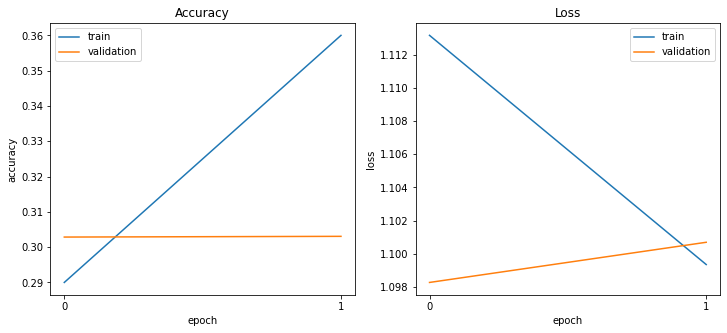

In [108]:
plot_accuracy_and_loss_graphs(history)

## ## BERT Model for sequence classification - **2** Classes

In [109]:
gc.collect()

7311

In [110]:
train2 = train.copy()
dev2 = dev.copy()
test2 = test.copy()

Transform the dataset labels from 3 classes to 2

In [111]:
def binary_classification(label: str) -> int:
    return LABELS2[label]

train2['gold_label_int'] = train2['gold_label'].apply(binary_classification)
dev2['gold_label_int'] = dev2['gold_label'].apply(binary_classification)
test2['gold_label_int'] = test2['gold_label'].apply(binary_classification)

In [112]:
train_tensor2 = create_tensor_dataset(train2)
dev_tensor2 = create_tensor_dataset(dev2)
test_tensor2 = create_tensor_dataset(test2)

In [113]:
train_loader2 = DataLoader(train_tensor2, batch_size=BATCH_SIZE, sampler=RandomSampler(train_tensor2))
dev_loader2 = DataLoader(dev_tensor2, batch_size=BATCH_SIZE, sampler=SequentialSampler(dev_tensor2))
test_loader2 = DataLoader(test_tensor2, batch_size=BATCH_SIZE)

In [114]:
model2 = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2, output_attentions=False, output_hidden_states=False)
model2.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Training

In [115]:
if not os.path.isdir(MODEL_PATH2):
    Train(
        model=model2,
        train=train_loader2,
        eval=dev_loader2,
        epoch=MAX_EPOCH,
        model_save_path=MODEL_PATH2,
        history_save_path=MODEL_HISTORY_PATH2
    )
    
else:
    print(f'Model version {MODEL_VERSION2} already exists')

Epoch 1/2


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/2


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

### Testing

In [116]:
l_model2 = BertForSequenceClassification.from_pretrained(MODEL_PATH2)
l_model2.to(device)

predictions2, labels2 = Train.test(model=l_model2, loader=test_loader2)

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

### Classification reports
f1 score included

In [117]:
print(classification_report(predictions2, labels2, labels=np.unique(labels2), zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        99
           1       0.00      0.00      0.00         0

    accuracy                           0.65        99
   macro avg       0.50      0.32      0.39        99
weighted avg       1.00      0.65      0.79        99



### History & Overfitting test

In [118]:
history2 = pd.read_csv(MODEL_HISTORY_PATH2)
history2

,epoch,training_loss,training_accuracy,validation_loss,validation_accuracy
0,0,0.647729,0.67,0.631876,0.676327
1,1,0.630105,0.67,0.626883,0.676327


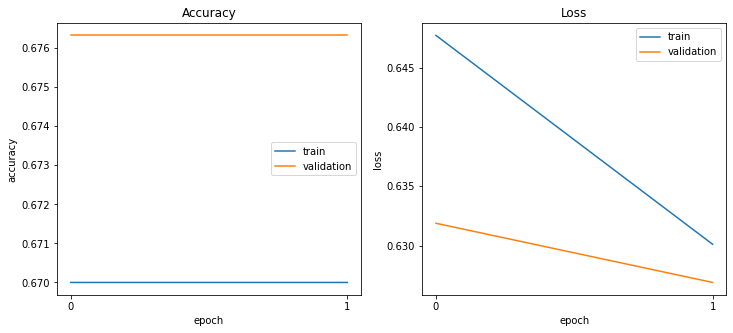

In [119]:
plot_accuracy_and_loss_graphs(history2)

### For kaggle only
Clean and zip the output

In [ ]:
!zip -r ./output.zip ./*

In [ ]:
!rm -rf ./data ./saved_model ./saved_model2